<h1>Model training and testing

In [9]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import os
import pandas as pd
from torch.nn import HuberLoss, MSELoss, L1Loss

# Lists to store models and scalers
models = {}
scalers = {}
encoders = {}
input_sizes = {}
metrics = {} # for model performance analysis
test_indices = {} # for testing based on category

# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# PyTorch Dataset Class
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

input_dir = r"E:\MA_data\WPPs+production+reforecast"

for file in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file)
    if os.path.isfile(file_path):  # Ensure it's a file (not a folder)
        lead_time = int(file.split("_")[-1].replace(".json", ""))
        with open(file_path, "r", encoding="utf-8") as file:
            forecast_data = json.load(file)

    print(f"Processing lead time: {lead_time}")

    print(f"    Data preparation")

    all_turbine_types = []
    all_hub_heights = []
    all_capacities = []
    all_commissioning_dates = []
    all_production_data = []

    for unique_key, wpp in forecast_data.items():
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Time Series"])

    # One-Hot-Encoding for turbine types
    encoder = OneHotEncoder(sparse_output=False)
    turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

    # convert to datetime
    standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

    # calculate age
    ref_date = pd.Timestamp("2024-12-01")
    ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

    # create combined features and output lists
    combined_features_raw = []
    output_raw = []
    
    # convert data in feature arrays
    for idx, production_data in enumerate(all_production_data):
        num_rows = len(production_data)

        # Repetitions for common features
        turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
        hub_height_repeated = np.full((num_rows, 1), float(all_hub_heights[idx]))
        age_repeated = np.full((num_rows, 1), ages[idx])

        # Extract production values and wind speeds
        production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
        wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

        # combine all features
        combined_chunk = np.hstack((
            turbine_type_repeated,
            hub_height_repeated,
            age_repeated,
            wind_speeds
        ))

        # add the data
        combined_features_raw.append(combined_chunk)
        output_raw.append(production_values)

    # combine all data chunks to one array
    combined_features = np.vstack(combined_features_raw)
    output = np.vstack(output_raw)

    # Interpolate missing values (linear interpolation) in pandas
    wind_speed_series = pd.Series(combined_features[:, -1])
    wind_speed_series.interpolate(method='linear', inplace=True)
    combined_features[:, -1] = wind_speed_series.to_numpy()

    # round all values to four decimal places
    combined_features = np.round(combined_features, decimals=4)
    output = np.round(output, decimals=4)
        
    # Normalise numerical features
    scaler_wind = StandardScaler()
    scaler_ages = StandardScaler()
    scaler_hub_heights = StandardScaler()

    # Skalieren der einzelnen Features
    combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
    combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
    combined_features[:, -3] = scaler_hub_heights.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale hub heights
    
    # Convert to PyTorch Dataset
    dataset = WindPowerDataset(combined_features, output)
    
    params = {"batch_size": 128,
              "lr": 0.00010155,
              "number_epochs": 10}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train-test split
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    torch.manual_seed(0)
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # shuffling doesn't matter here, has already taken place during random_split
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)
    
    # Model setup
    input_size = combined_features.shape[1]

    # use static instead of dynamic computational graphs
    model = torch.jit.script(MLP(input_size=input_size)).to(device)
    model.to(device)
    
    # Trainings-Konfiguration
    mae_criterion = L1Loss()
    mse_criterion = MSELoss()
    huber_criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # Training
    print(f"    Training")
    for epoch in range(params["number_epochs"]):
        print(f"        Epoch {epoch + 1}/{params['number_epochs']}")
        model.train()
        train_loss_mae, train_loss_mse, train_loss_huber = 0, 0, 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            # Calculate metrics for each criterion
            loss_mae = mae_criterion(outputs, batch_y)
            loss_mse = mse_criterion(outputs, batch_y)
            loss_huber = huber_criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss_huber.backward()
            optimizer.step()

            # Accumulate metrics for logging
            train_loss_mae += loss_mae.item()
            train_loss_mse += loss_mse.item()
            train_loss_huber += loss_huber.item()

        train_loss_mae /= len(train_loader)
        train_loss_mse /= len(train_loader)
        train_loss_huber /= len(train_loader)

    # Testen
    print(f"    Testing")
    model.eval()

    test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            
            test_loss_mae += mae_criterion(preds, batch_y).item()
            test_loss_mse += mse_criterion(preds, batch_y).item()
            test_loss_huber += huber_criterion(preds, batch_y).item()

    test_loss_mae /= len(test_loader)
    test_loss_mse /= len(test_loader)
    test_loss_huber /= len(test_loader)
    
    models[lead_time] = model.state_dict()
    
    scalers[lead_time] = {
        "winds": scaler_wind,
        "ages": scaler_ages,
        "hub_heights": scaler_hub_heights
    }

    encoders[lead_time] = encoder

    input_sizes[lead_time] = input_size

    metrics[lead_time] = {
        "Training": {
            "Huber": train_loss_huber,
            "MAE": train_loss_mae,
            "MSE":train_loss_mse,
            "RMSE": np.sqrt(train_loss_mse)
        },
        "Testing": {
            "Huber": test_loss_huber,
            "MAE": test_loss_mae,
            "MSE": test_loss_mse,
            "RMSE": np.sqrt(test_loss_mse)
        },
    }

    test_indices[lead_time] = test_dataset.indices

# Save all parameters
torch.save(models, "parameters/models.pth")
joblib.dump(scalers, "parameters/scalers.pkl")
joblib.dump(encoders, "parameters/encoders.pkl")
joblib.dump(input_sizes, "parameters/input_sizes.pkl")
joblib.dump(metrics, "parameters/metrics.pkl")
joblib.dump(test_indices, "parameters/test_indices.pkl")
print("All parameters saved successfully.")

Processing lead time: 0
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 102
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 105
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 108
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
 

<h1>Model training for deployment

In [ ]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib
import os
import pandas as pd
from torch.nn import HuberLoss, MSELoss, L1Loss

# Lists to store models and scalers
models = {}
scalers = {}
encoders = {}
input_sizes = {}
metrics = {}

# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# PyTorch Dataset Class
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

input_dir = r"E:\MA_data\WPPs+production+reforecast"

for file in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file)
    if os.path.isfile(file_path):  # Ensure it's a file (not a folder)
        lead_time = int(file.split("_")[-1].replace(".json", ""))
        with open(file_path, "r", encoding="utf-8") as file:
            forecast_data = json.load(file)

    print(f"Processing lead time: {lead_time}")

    print(f"    Data preparation")

    all_turbine_types = []
    all_hub_heights = []
    all_capacities = []
    all_commissioning_dates = []
    all_production_data = []

    for unique_key, wpp in forecast_data.items():
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Time Series"])

    # One-Hot-Encoding for turbine types
    encoder = OneHotEncoder(sparse_output=False)
    turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

    # convert to datetime
    standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

    # calculate age
    ref_date = pd.Timestamp("2024-12-01")
    ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

    # create combined features and output lists
    combined_features_raw = []
    output_raw = []
    
    # convert data in feature arrays
    for idx, production_data in enumerate(all_production_data):
        num_rows = len(production_data)

        # Repetitions for common features
        turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
        hub_height_repeated = np.full((num_rows, 1), float(all_hub_heights[idx]))
        age_repeated = np.full((num_rows, 1), ages[idx])

        # Extract production values and wind speeds
        production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
        wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

        # combine all features
        combined_chunk = np.hstack((
            turbine_type_repeated,
            hub_height_repeated,
            age_repeated,
            wind_speeds
        ))

        # add the data
        combined_features_raw.append(combined_chunk)
        output_raw.append(production_values)

    # combine all data chunks to one array
    combined_features = np.vstack(combined_features_raw)
    output = np.vstack(output_raw)

    # Interpolate missing values (linear interpolation) in pandas
    wind_speed_series = pd.Series(combined_features[:, -1])
    wind_speed_series.interpolate(method='linear', inplace=True)
    combined_features[:, -1] = wind_speed_series.to_numpy()

    # round all values to four decimal places
    combined_features = np.round(combined_features, decimals=4)
    output = np.round(output, decimals=4)
        
    # Normalise numerical features
    scaler_wind = StandardScaler()
    scaler_ages = StandardScaler()
    scaler_hub_heights = StandardScaler()

    # Skalieren der einzelnen Features
    combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
    combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
    combined_features[:, -3] = scaler_hub_heights.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale hub heights
    
    # Convert to PyTorch Dataset
    dataset = WindPowerDataset(combined_features, output)
    
    params = {"batch_size": 128,
              "lr": 0.00010155,
              "number_epochs": 10}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # shuffling matters here
    data_loader = DataLoader(dataset, batch_size=params["batch_size"], shuffle=True)
    
    # Model setup
    input_size = combined_features.shape[1]

    # use static instead of dynamic computational graphs
    model = torch.jit.script(MLP(input_size=input_size)).to(device)
    model.to(device)
    
    # Trainings-Konfiguration
    mae_criterion = L1Loss()
    mse_criterion = MSELoss()
    huber_criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # Training
    print(f"    Training")
    for epoch in range(params["number_epochs"]):
        print(f"        Epoch {epoch + 1}/{params['number_epochs']}")
        model.train()
        train_loss_mae, train_loss_mse, train_loss_huber = 0, 0, 0

        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            
            # Calculate metrics for each criterion
            loss_mae = mae_criterion(outputs, batch_y)
            loss_mse = mse_criterion(outputs, batch_y)
            loss_huber = huber_criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss_huber.backward()
            optimizer.step()

            # Accumulate metrics for logging
            train_loss_mae += loss_mae.item()
            train_loss_mse += loss_mse.item()
            train_loss_huber += loss_huber.item()

        train_loss_mae /= len(data_loader)
        train_loss_mse /= len(data_loader)
        train_loss_huber /= len(data_loader)
    
    models[lead_time] = model.state_dict()
    
    scalers[lead_time] = {
        "winds": scaler_wind,
        "ages": scaler_ages,
        "hub_heights": scaler_hub_heights
    }

    encoders[lead_time] = encoder

    input_sizes[lead_time] = input_size

    metrics[lead_time] = {
        "Huber": train_loss_huber,
        "MAE": train_loss_mae,
        "MSE":train_loss_mse,
        "RMSE": np.sqrt(train_loss_mse)
    }

# Save all parameters
torch.save(models, "parameters_deployment/models.pth")
joblib.dump(scalers, "parameters_deployment/scalers.pkl")
joblib.dump(encoders, "parameters_deployment/encoders.pkl")
joblib.dump(input_sizes, "parameters_deployment/input_sizes.pkl")
joblib.dump(metrics, "parameters_deployment/metrics.pkl")
print("All parameters saved successfully.")

Processing lead time: 0
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
Processing lead time: 102
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
Processing lead time: 105
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
Processing lead time: 108
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/1

<h1>Check if input sizes and encoders are the same for all lead times

In [2]:
import joblib

print("Model C for testing")

input_sizes = joblib.load("parameters/input_sizes.pkl")
encoders = joblib.load("parameters/encoders.pkl")

# Check if all input sizes are the same for all lead times
unique_input_sizes = set(input_sizes.values())

if len(unique_input_sizes) == 1:
    print(f"✅ All lead times have the same input size: {unique_input_sizes.pop()}")
else:
    print(f"⚠️ Different input sizes detected: {unique_input_sizes}")

# Check if all encoders have the same categories
encoder_refs = list(encoders.values())
first_encoder_categories = encoder_refs[0].categories_

same_encoders = all(
    all((cat1 == cat2).all() for cat1, cat2 in zip(enc.categories_, first_encoder_categories))
    for enc in encoder_refs
)

if same_encoders:
    print("✅ All encoders have identical categories across lead times.")
else:
    print("⚠️ Encoders have different categories across lead times!")


print("Model C for deployment")

input_sizes = joblib.load("parameters_deployment/input_sizes.pkl")
encoders = joblib.load("parameters_deployment/encoders.pkl")

# Check if all input sizes are the same for all lead times
unique_input_sizes = set(input_sizes.values())

if len(unique_input_sizes) == 1:
    print(f"✅ All lead times have the same input size: {unique_input_sizes.pop()}")
else:
    print(f"⚠️ Different input sizes detected: {unique_input_sizes}")

# Check if all encoders have the same categories
encoder_refs = list(encoders.values())
first_encoder_categories = encoder_refs[0].categories_

same_encoders = all(
    all((cat1 == cat2).all() for cat1, cat2 in zip(enc.categories_, first_encoder_categories))
    for enc in encoder_refs
)

if same_encoders:
    print("✅ All encoders have identical categories across lead times.")
else:
    print("⚠️ Encoders have different categories across lead times!")

Model C for testing
✅ All lead times have the same input size: 56
✅ All encoders have identical categories across lead times.
Model C for deployment
✅ All lead times have the same input size: 56
✅ All encoders have identical categories across lead times.


<h1>Further investigation</h1>
1. Model testing by groups in certain categories<br>
2. Determination of standard deviation and bias<br>
3. Creation of vector with itemised production and outputs for histograms

In [ ]:
import numpy as np
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib
import os
import pandas as pd
from torch.nn import HuberLoss, MSELoss, L1Loss

encoders = joblib.load("parameters/encoders.pkl")
input_sizes = joblib.load("parameters/input_sizes.pkl")
scalers = joblib.load("parameters/scalers.pkl")
test_indices = joblib.load("parameters/test_indices.pkl") # same random_split as during training of the model, so that testing now only is done on unseen data 
model_state_dicts = torch.load("parameters/models.pth", weights_only=True)

metrics = {}
metrics_detailed = {}
all_values_itemised = {} # for histograms with error distributions

# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# PyTorch Dataset Class
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

params = {"batch_size": 128,
        "lr": 0.00010155,
        "number_epochs": 10}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mae_criterion = L1Loss()
mse_criterion = MSELoss()
huber_criterion = HuberLoss()

input_dir = r"E:\MA_data\WPPs+production+reforecast"

for file in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file)
    if not os.path.isfile(file_path):  # Ensure it's a file (not a folder)
        continue
    
    lead_time = int(file.split("_")[-1].replace(".json", ""))
    with open(file_path, "r", encoding="utf-8") as file:
        forecast_data = json.load(file)

    print(f"Processing lead time: {lead_time}")

    print(f"    Data preparation")

    metrics[lead_time] = {}

    encoder = encoders[lead_time]
    input_size = input_sizes[lead_time]
    scalers_ = scalers[lead_time]
    test_indices_ = test_indices[lead_time]
    model_state_dict = model_state_dicts[lead_time]

    all_turbine_types = []
    all_hub_heights = []
    all_capacities = []
    all_commissioning_dates = []
    all_production_data = []
    all_iso_codes = []
    all_types = []

    for unique_key, wpp in forecast_data.items():
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Time Series"])
        all_iso_codes.append(wpp["ISO_code"])
        all_types.append(wpp["Type"])

    # One-Hot-Encoding for turbine types
    turbine_types_onehot = encoder.transform(np.array(all_turbine_types).reshape(-1, 1))

    # convert to datetime
    standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

    # calculate age
    ref_date = pd.Timestamp("2024-12-01")
    ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

    # create combined features and output lists
    combined_features_all = []
    output_raw = []
    
    # convert data in feature arrays
    for idx, production_data in enumerate(all_production_data):
        num_rows = len(production_data)

        # Repetitions for common features
        turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
        hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
        capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
        age_repeated = np.full((num_rows, 1), ages[idx])
        iso_codes_repeated = np.full((num_rows, 1), all_iso_codes[idx])
        types_repeated = np.full((num_rows, 1), all_types[idx])

        # Extract production values and wind speeds
        production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
        wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

        # combine all features
        combined_chunk = np.hstack((
            turbine_type_repeated,
            hub_height_repeated,
            capacity_repeated,
            age_repeated,
            iso_codes_repeated,
            types_repeated,
            wind_speeds
        ))

        # add the data
        combined_features_all.append(combined_chunk)
        output_raw.append(production_values)

    # combine all data chunks to one array
    combined_features_all = np.vstack(combined_features_all)
    output = np.vstack(output_raw)

    # Interpolate missing values (linear interpolation) in pandas
    wind_speed_series = pd.Series(combined_features_all[:, -1]).astype(float)
    wind_speed_series = wind_speed_series.infer_objects(copy=False)
    wind_speed_series.interpolate(method='linear', inplace=True)
    combined_features_all[:, -1] = wind_speed_series.to_numpy()
        
    # Skalieren der einzelnen Features
    combined_features = np.hstack((
        combined_features_all[:, 0:len(encoder.categories_[0])].astype(float),
        scalers_["hub_heights"].transform(combined_features_all[:, -6].astype(float).reshape(-1, 1)),
        scalers_["ages"].transform(combined_features_all[:, -4].astype(float).reshape(-1, 1)),
        scalers_["winds"].transform(combined_features_all[:, -1].astype(float).reshape(-1, 1))
    ))

    # round all values to four decimal places
    combined_features = np.round(combined_features, decimals=4)
    output = np.round(output, decimals=4)
    
    # use static instead of dynamic computational graphs
    model = torch.jit.script(MLP(input_size=input_size))
    model.load_state_dict(model_state_dict)
    model.eval()
    model.to(device)
    
    # Testen
    print(f"    Testing")
    model.eval()

    # Extract features from test_dataset_all
    test_features_all = combined_features_all[test_indices_]
    test_features = combined_features[test_indices_]
    test_output = output[test_indices_]
    
    ##################### 1. Model testing by groups in certain categories ##################

    # Indices for categorical features
    group_indices = {
        "turbine type": list(range(len(encoder.categories_[0]))),  # Multiple indices for one-hot encoding
        "hub height": len(encoder.categories_[0]),
        "capacity": len(encoder.categories_[0]) + 1,
        "age": len(encoder.categories_[0]) + 2,
        "iso code": len(encoder.categories_[0]) + 3,
        "type": len(encoder.categories_[0]) + 4,
        "wind speed": len(encoder.categories_[0]) + 5
    }
    
    interval_length = 1.0  # Binning for continuous wind speeds

    for testing_group, index in group_indices.items():

        if testing_group == "turbine type":
            unique_values = encoder.categories_[0]  # Get actual turbine type names
        elif testing_group == "wind speed":
            unique_values = np.unique(np.floor(test_features_all[:, index].astype(float) / interval_length) * interval_length) # as an exception, search for unique values in test_features_all and not combined_features_all in this category of "wind speeds", because for high extremely wind speeds, it may be that a value only occurs in the latter and not the first
        else:
            unique_values = np.unique(combined_features_all[:, index])  # Normal numerical features

        group_results = {}

        for i, value in enumerate(unique_values):

            if testing_group == "turbine type":
                mask = test_features_all[:, index[i]].astype(float) == 1 # convert <U32 type of column of test_features_all to float, because "value" (0 and 1) has same data type
            elif testing_group == "wind speed":
                mask = (np.floor(test_features_all[:, index].astype(float) / interval_length) * interval_length) == value  # convert <U32 type of column of test_features_all to float, because <U32 data type doesn't allow division
            else:
                mask = test_features_all[:, index] == value # keep <U32 type of column of test_features_all, because "value" has same data type

            test_features_filtered = test_features[mask]
            test_output_filtered = test_output[mask]

            # Convert to PyTorch Dataset
            filtered_test_dataset = WindPowerDataset(test_features_filtered, test_output_filtered)

            # shuffling doesn't matter here, has already taken place during random_split, in the same fashion as during training of the model
            filtered_test_loader = DataLoader(filtered_test_dataset, batch_size=params["batch_size"], shuffle=False)

            test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

            with torch.no_grad():
                for batch_x, batch_y in filtered_test_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    preds = model(batch_x)

                    test_loss_mae += mae_criterion(preds, batch_y).item() # average loss of a single batch
                    test_loss_mse += mse_criterion(preds, batch_y).item()
                    test_loss_huber += huber_criterion(preds, batch_y).item()

            # Compute final test losses
            test_loss_mae /= len(filtered_test_loader)
            test_loss_mse /= len(filtered_test_loader)
            test_loss_huber /= len(filtered_test_loader)

            group_results[value] = {
                "Huber": test_loss_huber,
                "MAE": test_loss_mae,
                "MSE": test_loss_mse,
                "RMSE": np.sqrt(test_loss_mse),
                "Share": len(filtered_test_dataset) / len(test_dataset)
            }

        # Store per group results
        metrics[lead_time][testing_group] = group_results

    ######################## 2. Determination of standard deviation and bias ####################
    ######################## 3. Creation of vector with itemised production and outputs for histograms ####################

    test_dataset = WindPowerDataset(test_features, test_output)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)

    test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0
    outputs_itemised = []
    predictions_itemised = []
    all_residuals = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)
            
            test_loss_mae += mae_criterion(preds, batch_y).item()
            test_loss_mse += mse_criterion(preds, batch_y).item()
            test_loss_huber += huber_criterion(preds, batch_y).item()

            outputs_itemised.append(batch_y.detach().numpy())
            predictions_itemised.append(preds.detach().numpy())
            all_residuals.append(batch_y.cpu().numpy() - preds.cpu().numpy())

    # Compute final test losses
    test_loss_mae /= len(test_loader)
    test_loss_mse /= len(test_loader)
    test_loss_huber /= len(test_loader)

    # Flatten residuals into a single array
    all_residuals = np.concatenate(all_residuals)

    # Compute bias (mean error)
    bias = np.mean(all_residuals)

    # Compute standard deviation of residuals
    std_ddof0 = np.std(all_residuals, ddof=0)
    std_ddof1 = np.std(all_residuals, ddof=1)

    metrics_detailed[lead_time] = {
        "Huber": test_loss_huber,
        "MAE": test_loss_mae,
        "MSE": test_loss_mse,
        "RMSE_1": np.sqrt(test_loss_mse),
        "RMSE_2": np.sqrt(np.mean(all_residuals**2)),
        "MBE": bias,
        "STD_0": std_ddof0,
        "STD_1": std_ddof1
    }

    all_values_itemised[lead_time] = {
        "outputs": np.vstack(outputs_itemised),
        "predictions": np.vstack(predictions_itemised)
    }


#joblib.dump(metrics, "metrics_per_attribute/metrics.pkl")
joblib.dump(metrics_detailed, "metrics_per_attribute/metrics_detailed.pkl")
joblib.dump(all_values_itemised, "metrics_per_attribute/all_values_itemised.pkl")
print("Metrics saved successfully.")

Processing lead time: 0
    Data preparation
    Testing
Processing lead time: 102
    Data preparation
    Testing
Processing lead time: 105
    Data preparation
    Testing
Processing lead time: 108
    Data preparation
    Testing
Processing lead time: 111
    Data preparation
    Testing
Processing lead time: 114
    Data preparation
    Testing
Processing lead time: 117
    Data preparation
    Testing
Processing lead time: 12
    Data preparation
    Testing
Processing lead time: 120
    Data preparation
    Testing
Processing lead time: 123
    Data preparation
    Testing
Processing lead time: 126
    Data preparation
    Testing
Processing lead time: 129
    Data preparation
    Testing
Processing lead time: 132
    Data preparation
    Testing
Processing lead time: 135
    Data preparation
    Testing
Processing lead time: 138
    Data preparation
    Testing
Processing lead time: 141
    Data preparation
    Testing
Processing lead time: 144
    Data preparation
    Testing


<h1>Embedding instead of OneHotEncoding for turbine types

In [7]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import joblib
import os
import pandas as pd
from torch.nn import HuberLoss, MSELoss, L1Loss

# Lists to store models and scalers
models = {}
scalers = {}
turbine_type_to_index_dict = {}
input_sizes = {}
metrics = {} # for model performance analysis
test_indices = {} # for testing based on category

# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size, num_turbine_types):
        super(MLP, self).__init__()
        embedding_dim = 8 # or 8, etc.
        self.embedding = nn.Embedding(num_embeddings=num_turbine_types, embedding_dim=embedding_dim)
        self.fc1 = nn.Linear(input_size - 1 + embedding_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x, turbine_idx):
        embedded = self.embedding(turbine_idx)
        x = torch.cat([x, embedded], dim=1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# PyTorch Dataset Class
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return (torch.tensor(x[1:], dtype=torch.float32),      # all other features
                torch.tensor(int(x[0]), dtype=torch.long),     # turbine type index
                torch.tensor(y, dtype=torch.float32))


input_dir = r"E:\MA_data\WPPs+production+reforecast"

for file in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file)
    if os.path.isfile(file_path):  # Ensure it's a file (not a folder)
        lead_time = int(file.split("_")[-1].replace(".json", ""))
        with open(file_path, "r", encoding="utf-8") as file:
            forecast_data = json.load(file)

    print(f"Processing lead time: {lead_time}")

    print(f"    Data preparation")

    all_turbine_types = []
    all_hub_heights = []
    all_capacities = []
    all_commissioning_dates = []
    all_production_data = []

    for unique_key, wpp in forecast_data.items():
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Time Series"])

    unique_turbine_types = list(set(all_turbine_types))
    turbine_type_to_index = {turb: idx for idx, turb in enumerate(unique_turbine_types)}
    turbine_type_indices = np.array([turbine_type_to_index[t] for t in all_turbine_types])

    # convert to datetime
    standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

    # calculate age
    ref_date = pd.Timestamp("2024-12-01")
    ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

    # create combined features and output lists
    combined_features_raw = []
    output_raw = []
    
    # convert data in feature arrays
    for idx, production_data in enumerate(all_production_data):
        num_rows = len(production_data)

        # Repetitions for common features
        turbine_type_repeated = np.full((num_rows, 1), turbine_type_indices[idx])
        hub_height_repeated = np.full((num_rows, 1), float(all_hub_heights[idx]))
        age_repeated = np.full((num_rows, 1), ages[idx])

        # Extract production values and wind speeds
        production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1) / all_capacities[idx]
        wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

        # combine all features
        combined_chunk = np.hstack((
            turbine_type_repeated,
            hub_height_repeated,
            age_repeated,
            wind_speeds
        ))

        # add the data
        combined_features_raw.append(combined_chunk)
        output_raw.append(production_values)

    # combine all data chunks to one array
    combined_features = np.vstack(combined_features_raw)
    output = np.vstack(output_raw)

    # Interpolate missing values (linear interpolation) in pandas
    wind_speed_series = pd.Series(combined_features[:, -1])
    wind_speed_series.interpolate(method='linear', inplace=True)
    combined_features[:, -1] = wind_speed_series.to_numpy()

    # round all values to four decimal places
    combined_features = np.round(combined_features, decimals=4)
    output = np.round(output, decimals=4)
        
    # Normalise numerical features
    scaler_wind = StandardScaler()
    scaler_ages = StandardScaler()
    scaler_hub_heights = StandardScaler()

    # Skalieren der einzelnen Features
    combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
    combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
    combined_features[:, -3] = scaler_hub_heights.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale hub heights
    
    # Convert to PyTorch Dataset
    dataset = WindPowerDataset(combined_features, output)
    
    params = {"batch_size": 128,
              "lr": 0.00010155,
              "number_epochs": 10}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Train-test split
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    torch.manual_seed(0)
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
    # shuffling doesn't matter here, has already taken place during random_split
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)
    
    # Model setup
    input_size = combined_features.shape[1]

    # use static instead of dynamic computational graphs
    model = torch.jit.script(MLP(input_size=input_size, num_turbine_types=len(unique_turbine_types))).to(device)
    model.to(device)
    
    # Trainings-Konfiguration
    mae_criterion = L1Loss()
    mse_criterion = MSELoss()
    huber_criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])

    # Training
    print(f"    Training")
    for epoch in range(params["number_epochs"]):
        print(f"        Epoch {epoch + 1}/{params['number_epochs']}")
        model.train()
        train_loss_mae, train_loss_mse, train_loss_huber = 0, 0, 0

        for batch_x, batch_turb_idx, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x, batch_turb_idx)
            
            # Calculate metrics for each criterion
            loss_mae = mae_criterion(outputs, batch_y)
            loss_mse = mse_criterion(outputs, batch_y)
            loss_huber = huber_criterion(outputs, batch_y)

            optimizer.zero_grad()
            loss_huber.backward()
            optimizer.step()

            # Accumulate metrics for logging
            train_loss_mae += loss_mae.item()
            train_loss_mse += loss_mse.item()
            train_loss_huber += loss_huber.item()

        train_loss_mae /= len(train_loader)
        train_loss_mse /= len(train_loader)
        train_loss_huber /= len(train_loader)

    # Testen
    print(f"    Testing")
    model.eval()

    test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

    with torch.no_grad():
        for batch_x, batch_turb_idx, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x, batch_turb_idx)
            
            test_loss_mae += mae_criterion(preds, batch_y).item()
            test_loss_mse += mse_criterion(preds, batch_y).item()
            test_loss_huber += huber_criterion(preds, batch_y).item()

    test_loss_mae /= len(test_loader)
    test_loss_mse /= len(test_loader)
    test_loss_huber /= len(test_loader)
    
    models[lead_time] = model.state_dict()
    
    scalers[lead_time] = {
        "winds": scaler_wind,
        "ages": scaler_ages,
        "hub_heights": scaler_hub_heights
    }

    turbine_type_to_index_dict[lead_time] = turbine_type_to_index
    

    input_sizes[lead_time] = input_size

    metrics[lead_time] = {
        "Training": {
            "Huber": train_loss_huber,
            "MAE": train_loss_mae,
            "MSE":train_loss_mse,
            "RMSE": np.sqrt(train_loss_mse)
        },
        "Testing": {
            "Huber": test_loss_huber,
            "MAE": test_loss_mae,
            "MSE": test_loss_mse,
            "RMSE": np.sqrt(test_loss_mse)
        },
    }

    test_indices[lead_time] = test_dataset.indices

# Save all parameters
torch.save(models, "parameters_embedding/models.pth")
joblib.dump(scalers, "parameters_embedding/scalers.pkl")
joblib.dump(turbine_type_to_index_dict, "parameters_embedding/turbine_type_to_index_dict.pkl")
joblib.dump(input_sizes, "parameters_embedding/input_sizes.pkl")
joblib.dump(metrics, "parameters_embedding/metrics.pkl")
joblib.dump(test_indices, "parameters_embedding/test_indices.pkl")
print("All parameters saved successfully.")

Processing lead time: 0
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 102
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 105
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
        Epoch 9/10
        Epoch 10/10
    Testing
Processing lead time: 108
    Data preparation
    Training
        Epoch 1/10
        Epoch 2/10
        Epoch 3/10
        Epoch 4/10
        Epoch 5/10
        Epoch 6/10
        Epoch 7/10
        Epoch 8/10
 

C:\Users\alexa\AppData\Local\Temp\ipykernel_12188\242790788.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dicts = torch.load("parameters_embedding/models.p

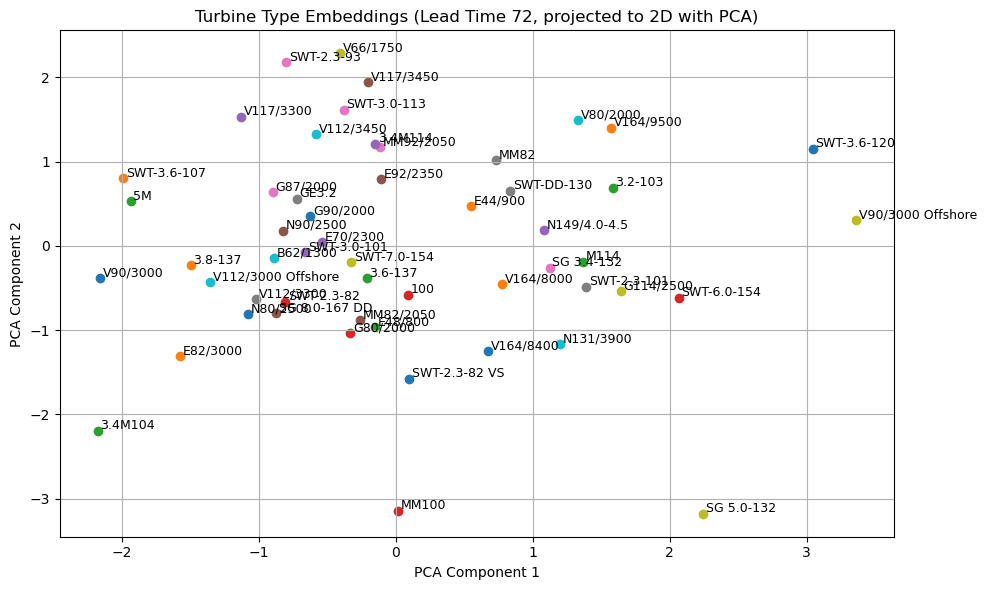

In [17]:
import torch
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Load model state dict
model_state_dicts = torch.load("parameters_embedding/models.pth")
state_dict_72 = model_state_dicts[72]

# Load turbine type mapping (same as during training)
turbine_type_to_index_dict = joblib.load("parameters_embedding/turbine_type_to_index_dict.pkl")
turbine_type_to_index = turbine_type_to_index_dict[72]
index_to_turbine_type = {v: k for k, v in turbine_type_to_index.items()}

# Define minimal model just to access embedding weights
class MLP_with_embedding(nn.Module):
    def __init__(self, input_size, num_turbine_types):
        super(MLP_with_embedding, self).__init__()
        self.embedding = nn.Embedding(num_turbine_types, 8)  # 8-dimensional embedding
        self.fc1 = nn.Linear(input_size - 1 + 8, 256)  # input_size includes turbine type as 1
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x, turbine_idx):
        embedded = self.embedding(turbine_idx)
        x = torch.cat([x, embedded], dim=1)
        x = self.relu1(self.input_layer(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Create model instance and load weights
model = MLP_with_embedding(input_size=input_sizes[72], num_turbine_types=len(turbine_type_to_index))
model.load_state_dict(state_dict_72)
embedding_weights = model.embedding.weight.detach().numpy()

# Reduce dimensions with PCA
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_weights)

# Plot
plt.figure(figsize=(10, 6))
for idx, (x, y) in enumerate(embedding_2d):
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, index_to_turbine_type[idx], fontsize=9)

plt.title("Turbine Type Embeddings (Lead Time 72, projected to 2D with PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
